In [3]:
from collections import defaultdict
import copy
import random
import os
import shutil
from urllib.request import urlretrieve

import albumentations as A
from albumentations.pytorch import ToTensorV2, ToTensor
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms

cudnn.benchmark = True

In [4]:
root_directory ='D:\\mango_deblur-gan-master\\img_ABC'

A_directory = os.path.join(root_directory, "A")
B_directory = os.path.join(root_directory, "B")
C_directory = os.path.join(root_directory, "C")

A_images_filepaths = sorted([os.path.join(A_directory, f) for f in os.listdir(A_directory)])
B_images_filepaths = sorted([os.path.join(B_directory, f) for f in os.listdir(B_directory)])
C_images_filepaths = sorted([os.path.join(C_directory, f) for f in os.listdir(C_directory)])
images_filepaths = [*A_images_filepaths, *B_images_filepaths, *C_images_filepaths]
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42)
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:45000]
val_images_filepaths = correct_images_filepaths[45000:-10]
test_images_filepaths = correct_images_filepaths[-10:]
print(len(train_images_filepaths), len(val_images_filepaths), len(test_images_filepaths))

45000 6990 10


In [5]:
def display_image_grid(images_filepaths, predicted_labels=(), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_label else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

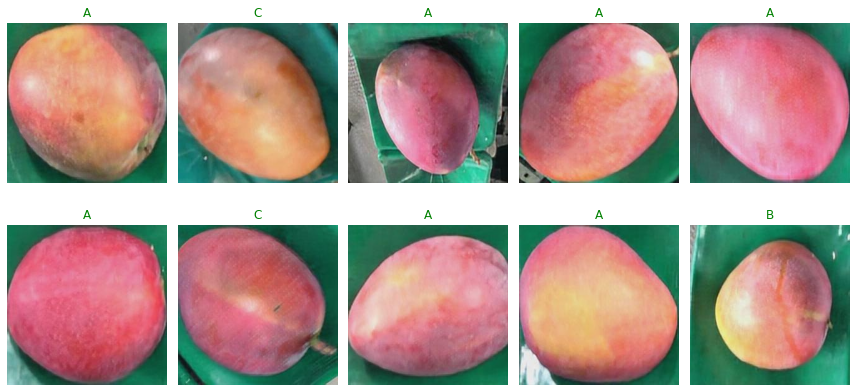

In [6]:
display_image_grid(test_images_filepaths)

In [7]:
class CatsVsDogsDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if os.path.normpath(image_filepath).split(os.sep)[-2] == "C":
            label = 2.0
        elif os.path.normpath(image_filepath).split(os.sep)[-2] == "B":
            label = 1.0
        else:
            label = 0.0
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image, label

In [8]:
train_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.RandomCrop(height=128, width=128),
        A.ChannelShuffle(),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensor(),
    ]
)
train_dataset = CatsVsDogsDataset(images_filepaths=train_images_filepaths, transform=train_transform)

val_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensor(),
    ]
)
val_dataset = CatsVsDogsDataset(images_filepaths=val_images_filepaths, transform=val_transform)

In [9]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5):
    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensor))])
    rows = samples // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))
    for i in range(samples):
        image, _ = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()    

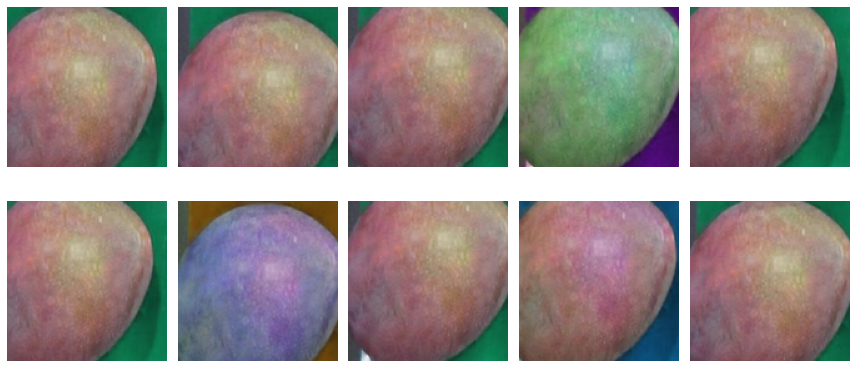

In [10]:
random.seed(42)
visualize_augmentations(train_dataset)

In [11]:
def calculate_accuracy(output, target):
#     output = torch.sigmoid(output) >= 0.5
#     target = target == 1.0
    output = torch.sigmoid(output)
    output = output.argmax(dim=1,keepdim=True)
    return torch.true_divide((target == output).sum(dim=0), output.size(0)).item()

In [12]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )

In [13]:
params = {
    "model": "resnet50",
    "device": "cuda",
    "lr": 0.001,
    "batch_size": 64,
    "num_workers": 0,
    "epochs": 100,
}

In [14]:
# model = getattr(models, params["model"])(pretrained=False, num_classes=3,)
# model = model.to(params["device"])
# criterion = nn.BCEWithLogitsLoss().to(params["device"])
# optimizer = torch.optim.Adam(model.parameters(), lr=params["lr"])

model = models.resnet50(pretrained=True, progress=False)
# print(model)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 3) # class_num
# print('[========================================================]')
# print(model)

model = model.to(params["device"])
criterion = nn.CrossEntropyLoss().to(params["device"])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\jason/.cache\torch\hub\checkpoints\resnet50-19c8e357.pth


In [15]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
train_loader = DataLoader(
    train_dataset, batch_size=params["batch_size"], shuffle=True, num_workers=params["num_workers"], pin_memory=True,
)
val_loader = DataLoader(
    val_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [17]:
train_acc = []
train_loss = []
val_acc = []
val_loss = []
def train(train_loader, model, criterion, optimizer, epoch, params):
    global train_acc, train_loss
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(params["device"], non_blocking=True)
        target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
        output = model(images)
        loss = criterion(output, torch.max(target, 1)[0].long())
        accuracy = calculate_accuracy(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Accuracy", accuracy)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    train_acc.append(accuracy)
    train_loss.append(loss.item())
def validate(val_loader, model, criterion, epoch, params):
    global val_acc, val_loss
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(params["device"], non_blocking=True)
            target = target.to(params["device"], non_blocking=True).float().view(-1, 1)
            output = model(images)
            loss = criterion(output, torch.max(target, 1)[0].long())
            accuracy = calculate_accuracy(output, target)

            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Accuracy", accuracy)
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
    val_acc.append(accuracy)
    val_loss.append(loss.item())

In [18]:
for epoch in range(1, params["epochs"] + 1):
    train(train_loader, model, criterion, optimizer, epoch, params)
    validate(val_loader, model, criterion, epoch, params)

Epoch: 1. Train.      Loss: 0.691 | Accuracy: 0.723: 100%|███████████████████████████| 704/704 [03:06<00:00,  3.77it/s]
Epoch: 1. Validation. Loss: 0.592 | Accuracy: 0.763: 100%|███████████████████████████| 110/110 [00:22<00:00,  5.00it/s]
Epoch: 2. Train.      Loss: 0.588 | Accuracy: 0.765: 100%|███████████████████████████| 704/704 [03:03<00:00,  3.83it/s]
Epoch: 2. Validation. Loss: 0.544 | Accuracy: 0.777: 100%|███████████████████████████| 110/110 [00:21<00:00,  5.09it/s]
Epoch: 3. Train.      Loss: 0.559 | Accuracy: 0.778: 100%|███████████████████████████| 704/704 [03:03<00:00,  3.84it/s]
Epoch: 3. Validation. Loss: 0.516 | Accuracy: 0.790: 100%|███████████████████████████| 110/110 [00:21<00:00,  5.08it/s]
Epoch: 4. Train.      Loss: 0.540 | Accuracy: 0.786: 100%|███████████████████████████| 704/704 [03:03<00:00,  3.84it/s]
Epoch: 4. Validation. Loss: 0.536 | Accuracy: 0.791: 100%|███████████████████████████| 110/110 [00:20<00:00,  5.26it/s]
Epoch: 5. Train.      Loss: 0.526 | Accu

Epoch: 69. Train.      Loss: 0.047 | Accuracy: 0.983: 100%|██████████████████████████| 704/704 [03:03<00:00,  3.83it/s]
Epoch: 69. Validation. Loss: 1.232 | Accuracy: 0.781: 100%|██████████████████████████| 110/110 [00:21<00:00,  5.19it/s]
Epoch: 70. Train.      Loss: 0.049 | Accuracy: 0.982: 100%|██████████████████████████| 704/704 [03:03<00:00,  3.83it/s]
Epoch: 70. Validation. Loss: 1.387 | Accuracy: 0.778: 100%|██████████████████████████| 110/110 [00:21<00:00,  5.16it/s]
Epoch: 71. Train.      Loss: 0.051 | Accuracy: 0.982: 100%|██████████████████████████| 704/704 [03:03<00:00,  3.83it/s]
Epoch: 71. Validation. Loss: 1.268 | Accuracy: 0.785: 100%|██████████████████████████| 110/110 [00:21<00:00,  5.15it/s]
Epoch: 72. Train.      Loss: 0.049 | Accuracy: 0.983: 100%|██████████████████████████| 704/704 [03:03<00:00,  3.83it/s]
Epoch: 72. Validation. Loss: 1.288 | Accuracy: 0.770: 100%|██████████████████████████| 110/110 [00:21<00:00,  5.17it/s]
Epoch: 73. Train.      Loss: 0.044 | Acc

0.7678571820259095


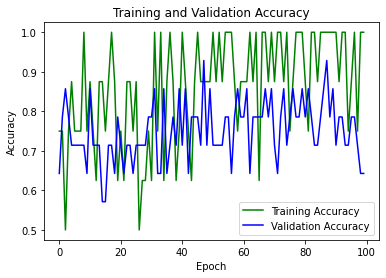

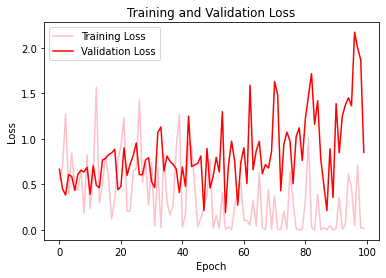

In [24]:
x=0
y=0
for i in val_acc[-(100//5):]:
    x+=1
    y+=i
print(y/x)

#accuracy plot
plt.plot(train_acc, color='green', label='Training Accuracy')
plt.plot(val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.figure()
#loss plot
plt.plot(train_loss, color='pink', label='Training Loss')

plt.plot(val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
class CatsVsDogsInferenceDataset(Dataset):
    def __init__(self, images_filepaths, transform=None):
        self.images_filepaths = images_filepaths
        self.transform = transform

    def __len__(self):
        return len(self.images_filepaths)

    def __getitem__(self, idx):
        image_filepath = self.images_filepaths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform is not None:
            image = self.transform(image=image)["image"]
        return image

test_transform = A.Compose(
    [
        A.SmallestMaxSize(max_size=160),
        A.CenterCrop(height=128, width=128),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)
test_dataset = CatsVsDogsInferenceDataset(images_filepaths=test_images_filepaths, transform=test_transform)
test_loader = DataLoader(
    test_dataset, batch_size=params["batch_size"], shuffle=False, num_workers=params["num_workers"], pin_memory=True,
)

In [ ]:
model = model.eval()
predicted_labels = []
with torch.no_grad():
    for images in test_loader:
        images = images.to(params["device"], non_blocking=True)
        output = model(images)
        predictions = (output.argmax(dim=1,keepdim=True))[:, 0].cpu().numpy()
#         predictions = (torch.sigmoid(output) >= 0.5)[:, 0].cpu().numpy()
#         predicted_labels += ["Cat" if is_cat else "Dog" for is_cat in predictions]
        for label in predictions:
            if label == 0:
                predicted_labels += 'A'
            elif label == 1:
                predicted_labels += 'B'
            else:
                predicted_labels += 'C'

In [ ]:
display_image_grid(test_images_filepaths, predicted_labels)